In [135]:
from tqdm import tqdm
import pickle
import pandas as pd
from pathlib import Path
import numpy as np
import scipy
import copy
import sys
import os
from typing import Optional, Union, Sequence, Mapping, List, Set
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import cm
import warnings
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics.pairwise import cosine_similarity,cosine_distances

sys.path.append('/mnt/c/Users/lslat/Code/')
sys.path.append('/mnt/c/Users/lslat/QiskitProjects/VariationalWavefunction/')

from quantum_kernel.code.utils import get_dataset
from quantum_kernel.code.visualization_utils import aggregate_shapes,filter_df
from quantum_kernel.code.kernel_measures.kernel_geometry import purity_average, purity_of_average

font = {'family': 'DejaVu Sans',
        'weight': 'bold',
        'size': 18}

rc('font', **font)

tqdm.pandas()
warnings.filterwarnings("ignore")


In [136]:
# Get kernel results for the different ml models and dataset.d
dfs = {}
folders = [
    ("/mnt/c/Users/lslat/Data/QK_project/results/Sparse_IQP/gennorm",'Sparse_IQP'),


]

for folder,prefix in folders:
    if prefix in dfs:
        temp = aggregate_shapes(folder,prefix)
        dfs[prefix] = pd.concat([dfs[prefix], temp])
    else:
        dfs[prefix] = aggregate_shapes(folder,prefix)


save_folder='/mnt/c/Users/lslat/Data/QK_project/figs/'

In [137]:
iqp_df=dfs['Sparse_IQP']

In [138]:
def compute_dataframe_kernel_eigenvalues(df: pd.DataFrame,filter: dict = {}, k: int = 1):
    """
    compute the kth largest kernel eigenvalues for a dataframe after filter. return filtered dataframe with new column 'kernel_eigenvalues'.
    """
    filtered_df=filter_df(df,filter)
    #-1* matrix so we get the 'kth lowest eigenvalues' then take absolute value to make positive.
    filtered_df['kernel_eigenvalues']=filtered_df.apply(lambda row: np.abs(scipy.linalg.eigh(-1*row.qkern_matrix_train,eigvals_only=True,subset_by_index=(0,k-1)))/row.qkern_matrix_train.shape[0], axis=1)
    return filtered_df

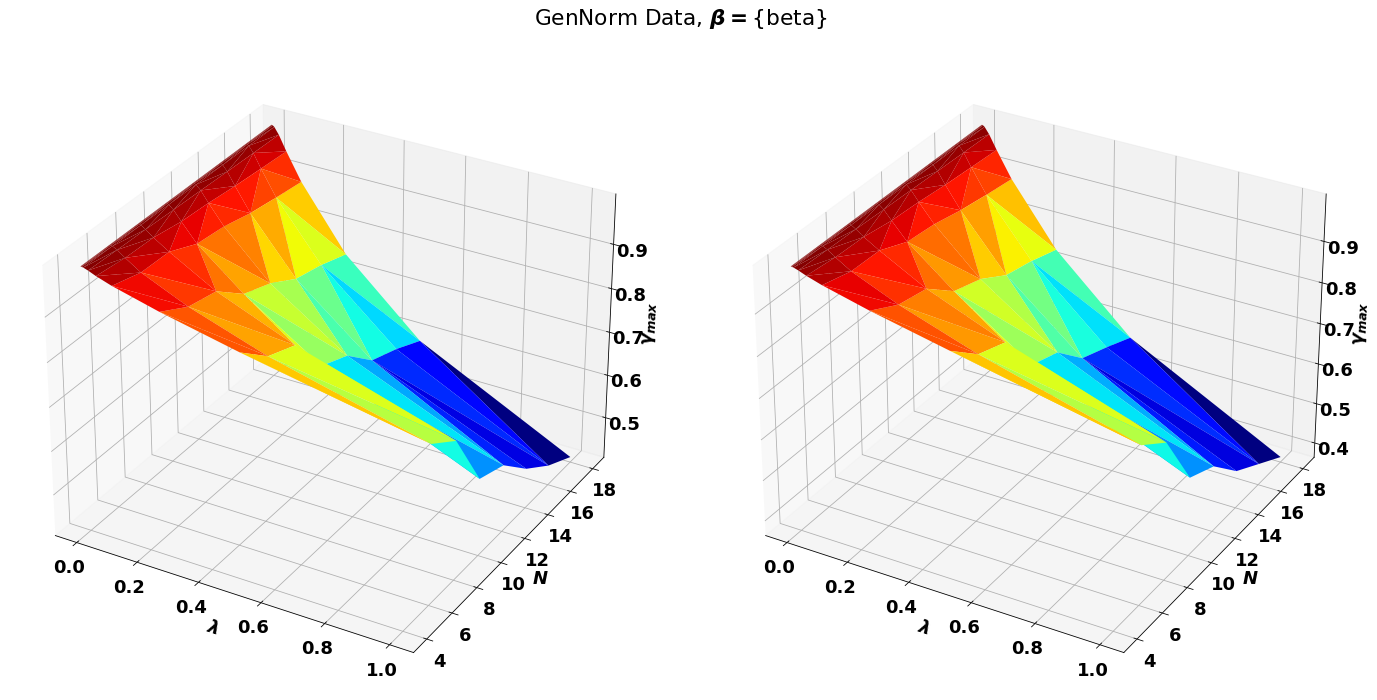

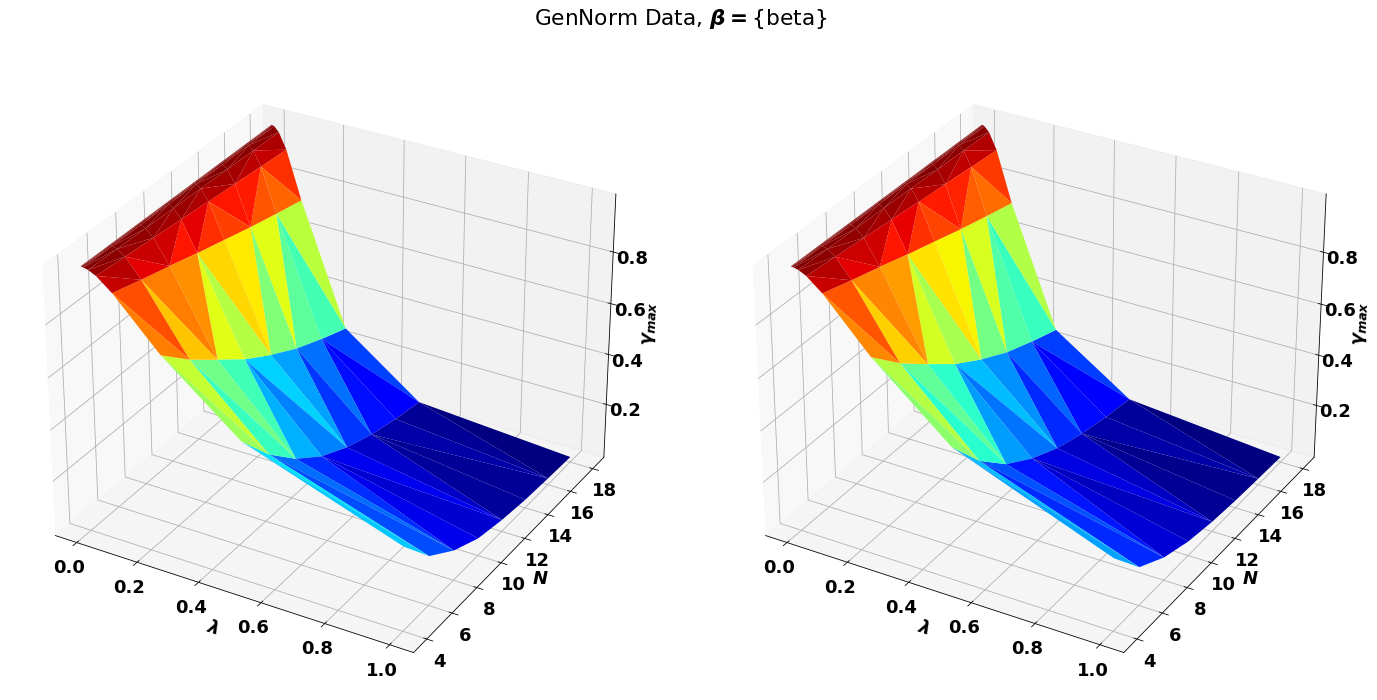

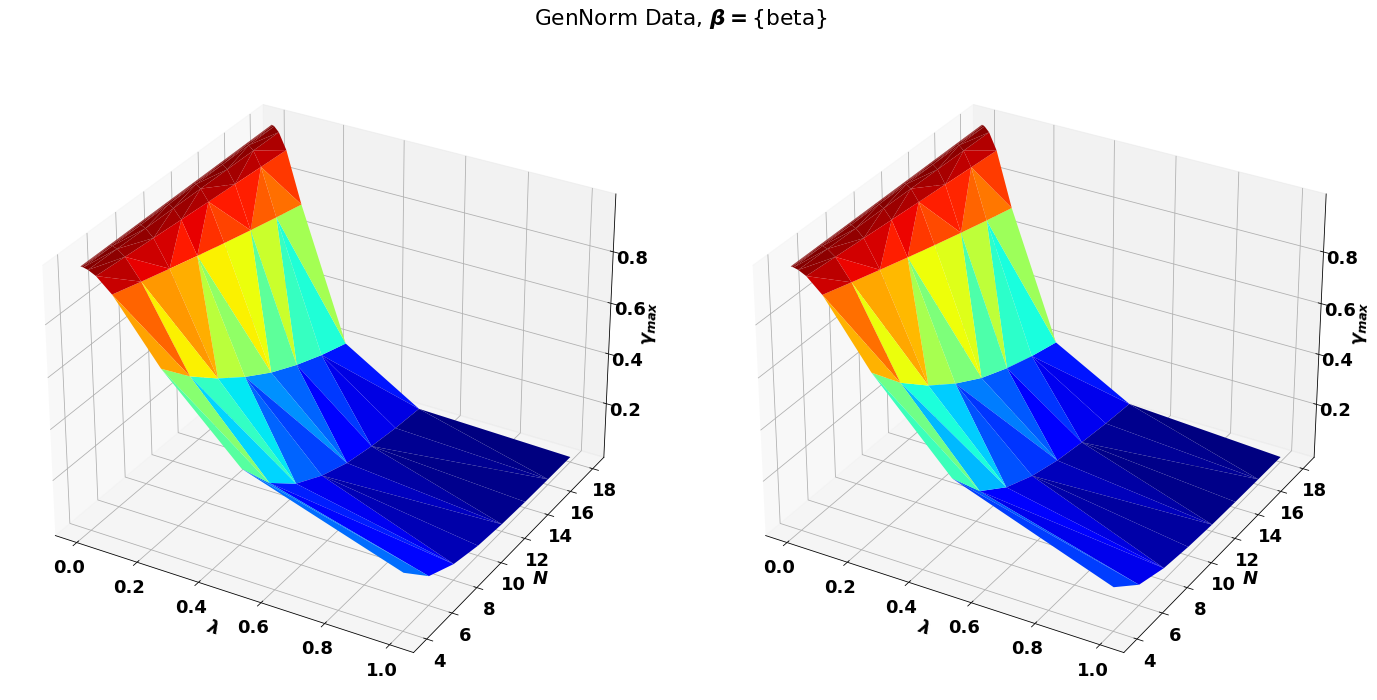

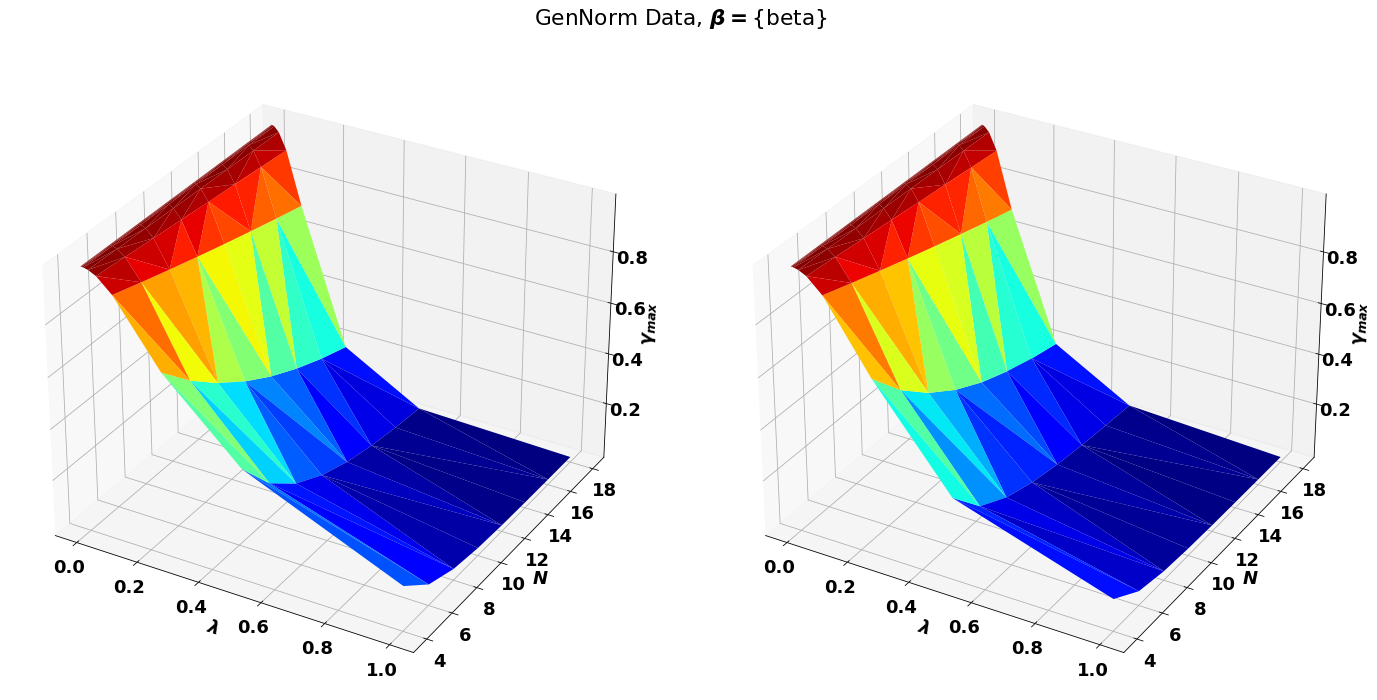

In [148]:
betas=[0.05,0.1,0.2,0.5,1.0,5.0]
for beta in betas:
    filter={'beta': beta}
    new_df=compute_dataframe_kernel_eigenvalues(iqp_df,filter,k=3)

    classical_df=new_df[(new_df['density']==0)]
    cl_x=classical_df.scaling_factor
    cl_y=classical_df.dataset_dim
    cl_z=classical_df.apply(lambda x: max(x.kernel_eigenvalues),axis=1)

    q_df=new_df[(new_df['density']!=0)]
    q_x=q_df.scaling_factor
    q_y=q_df.dataset_dim
    q_z=q_df.apply(lambda x: max(x.kernel_eigenvalues),axis=1)

    fig, axs = plt.subplots(1,2,subplot_kw={"projection": "3d"},figsize=(20,10))
    ax=axs[0]
    ax.plot_trisurf(cl_x,cl_y,cl_z,cmap=cm.jet)
    ax.set_xlabel('$\lambda$')
    ax.set_ylabel('$N$')
    ax.set_zlabel('$\gamma_{max}$')
    ax.set_title('Classical IQP')

    ax=axs[1]
    ax.plot_trisurf(q_x,q_y,q_z,cmap=cm.jet)
    ax.set_xlabel('$\lambda$')
    ax.set_ylabel('$N$')
    ax.set_zlabel('$\gamma_{max}$')
    ax.set_title('Quantum IQP')

    fig.suptitle(rf'GenNorm Data, $\beta=${beta}')
    fig.tight_layout()